In [ ]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import shapely.wkt
from shapely.geometry import mapping
import ast

In [ ]:
results = pd.read_csv("nyc_elections.csv")

In [ ]:
results["Unit Name"].unique()

array(['Public Counter', 'Manually Counted Emergency',
       'Absentee / Military', 'Federal', 'Special Presidential',
       'Affidavit', 'Joseph R. Biden / Kamala D. Harris (Democratic)',
       'Donald J. Trump / Michael R. Pence (Republican)',
       'Donald J. Trump / Michael R. Pence (Conservative)',
       'Joseph R. Biden / Kamala D. Harris (Working Families)',
       'Howie Hawkins / Angela Nicole Walker (Green)',
       'Jo Jorgensen / Jeremy Cohen (Libertarian)',
       'Brock Pierce / Karla Ballard (Independence)', 'Scattered'],
      dtype=object)

In [ ]:
candidates = [
  'Joseph R. Biden / Kamala D. Harris (Democratic)',
  'Joseph R. Biden / Kamala D. Harris (Working Families)',
  'Donald J. Trump / Michael R. Pence (Republican)',
  'Donald J. Trump / Michael R. Pence (Conservative)',
  'Howie Hawkins / Angela Nicole Walker (Green)',
  'Jo Jorgensen / Jeremy Cohen (Libertarian)',
  'Brock Pierce / Karla Ballard (Independence)',
]

In [ ]:
biden_names = [candidates[0], candidates[1]]
trump_names = [candidates[2], candidates[3]]

In [ ]:
biden_results = sum(map(lambda name: results.loc[name], biden_names))
trump_results = sum(map(lambda name: results.loc[name], trump_names))
totals = sum(map(lambda name: results.loc[name], candidates)) + results.loc["Scattered"].reindex(totals.index).fillna(0)

In [ ]:
biden_percentage = (biden_results / totals).fillna(0)
trump_percentage = (trump_results / totals).fillna(0)
biden_margin = biden_percentage - trump_percentage

In [ ]:
modzcta = pd.read_csv("Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv")

In [ ]:
modzcta_polygons = {}
for code, shape in zip(modzcta["MODZCTA"], modzcta["the_geom"]):
  modzcta_polygons[code] = shapely.wkt.loads(shape)

In [ ]:
nyed = pd.read_csv("nyed.csv")

In [ ]:
nyed_polygons = {}
for code, shape in zip(nyed["ElectDist"], nyed["the_geom"]):
  nyed_polygons[str(code)] = shapely.wkt.loads(shape)

In [ ]:
from collections import defaultdict

zipcode_eds = defaultdict(lambda: [])

for (ed, ed_shape) in nyed_polygons.items():
  for (code, zip_shape) in modzcta_polygons.items():
    if zip_shape.contains(ed_shape.representative_point()):
      zipcode_eds[code].append(ed)

In [ ]:
biden_margin_for_zipcode = {}
for (code, edcodes) in zipcode_eds.items():
  tot = 0
  biden_votes = 0
  trump_votes = 0
  for edcode in edcodes:
    ad = int(edcode[:2])
    ed = int(edcode[2:])
    if (ad, ed) in totals.index:
      tot += totals.loc[(ad, ed)]["Tally"]
      biden_votes += biden_results.loc[(ad, ed)]["Tally"]
      trump_votes += trump_results.loc[(ad, ed)]["Tally"]

  biden_p = biden_votes / tot if tot > 0 else 0
  trump_p = trump_votes / tot if tot > 0 else 0
  biden_margin_for_zipcode[code] = biden_p - trump_p

In [ ]:
covid_latest = pd.read_csv("last7days-by-modzcta.csv")

In [ ]:
covid_latest.set_index(["modzcta"], inplace=True)

In [ ]:
biden_margins = pd.DataFrame.from_dict(biden_margin_for_zipcode, orient="index").sort_index()
biden_margins.columns = ["biden_margin"]

In [ ]:
covid_vs_elections = pd.concat([covid_latest, biden_margins, modzcta.set_index(["MODZCTA"])[["pop_est"]]], axis=1).dropna()

In [ ]:
covid_vs_elections["rate_per_100k"] = covid_vs_elections["people_positive"] / covid_vs_elections["pop_est"] * 100000 / 7

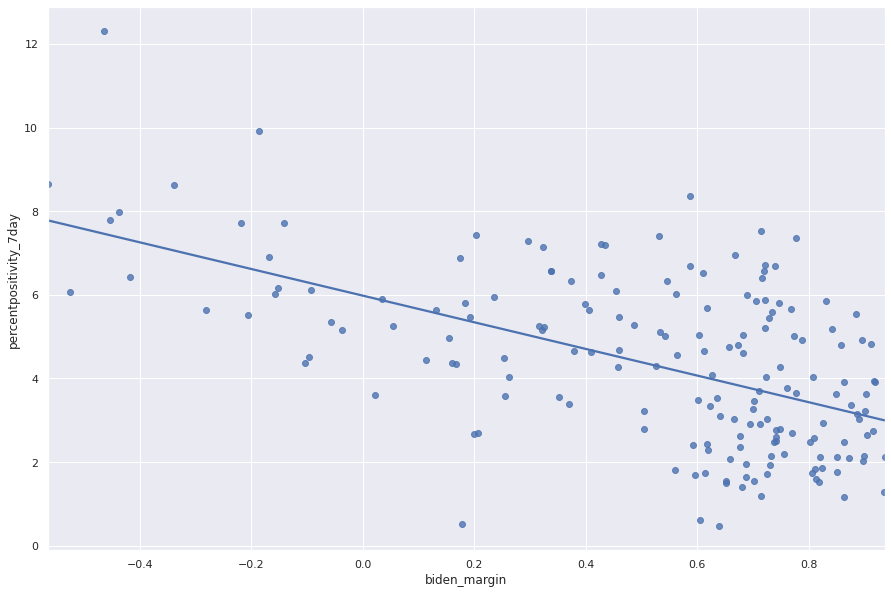

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.regplot(x='biden_margin', y='percentpositivity_7day', data=covid_vs_elections, ci=None, robust=True)

In [ ]:
lm = sm.OLS.from_formula("percentpositivity_7day ~ biden_margin", covid_vs_elections).fit()

In [ ]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.312
Model:                                OLS   Adj. R-squared:                  0.308
Method:                     Least Squares   F-statistic:                     79.49
Date:                    Thu, 03 Dec 2020   Prob (F-statistic):           6.27e-16
Time:                            04:30:32   Log-Likelihood:                -344.09
No. Observations:                     177   AIC:                             692.2
Df Residuals:                         175   BIC:                             698.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.0436      0.227     26.663      0.000       5.596       6.491
biden_margin    -3.2292      0.362     -8.915      0.000      -3.944      -2.514
==============================================================================
Omnibus:                        2.224   Durbin-Watson:                   1.047
Prob(Omnibus):                  0.329   Jarque-Bera (JB):                2.290
Skew:                           0.250   Prob(JB):                        0.318
Kurtosis:                       2.753   Cond. No.                         3.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm.model.exog_names

['Intercept', 'biden_margin']

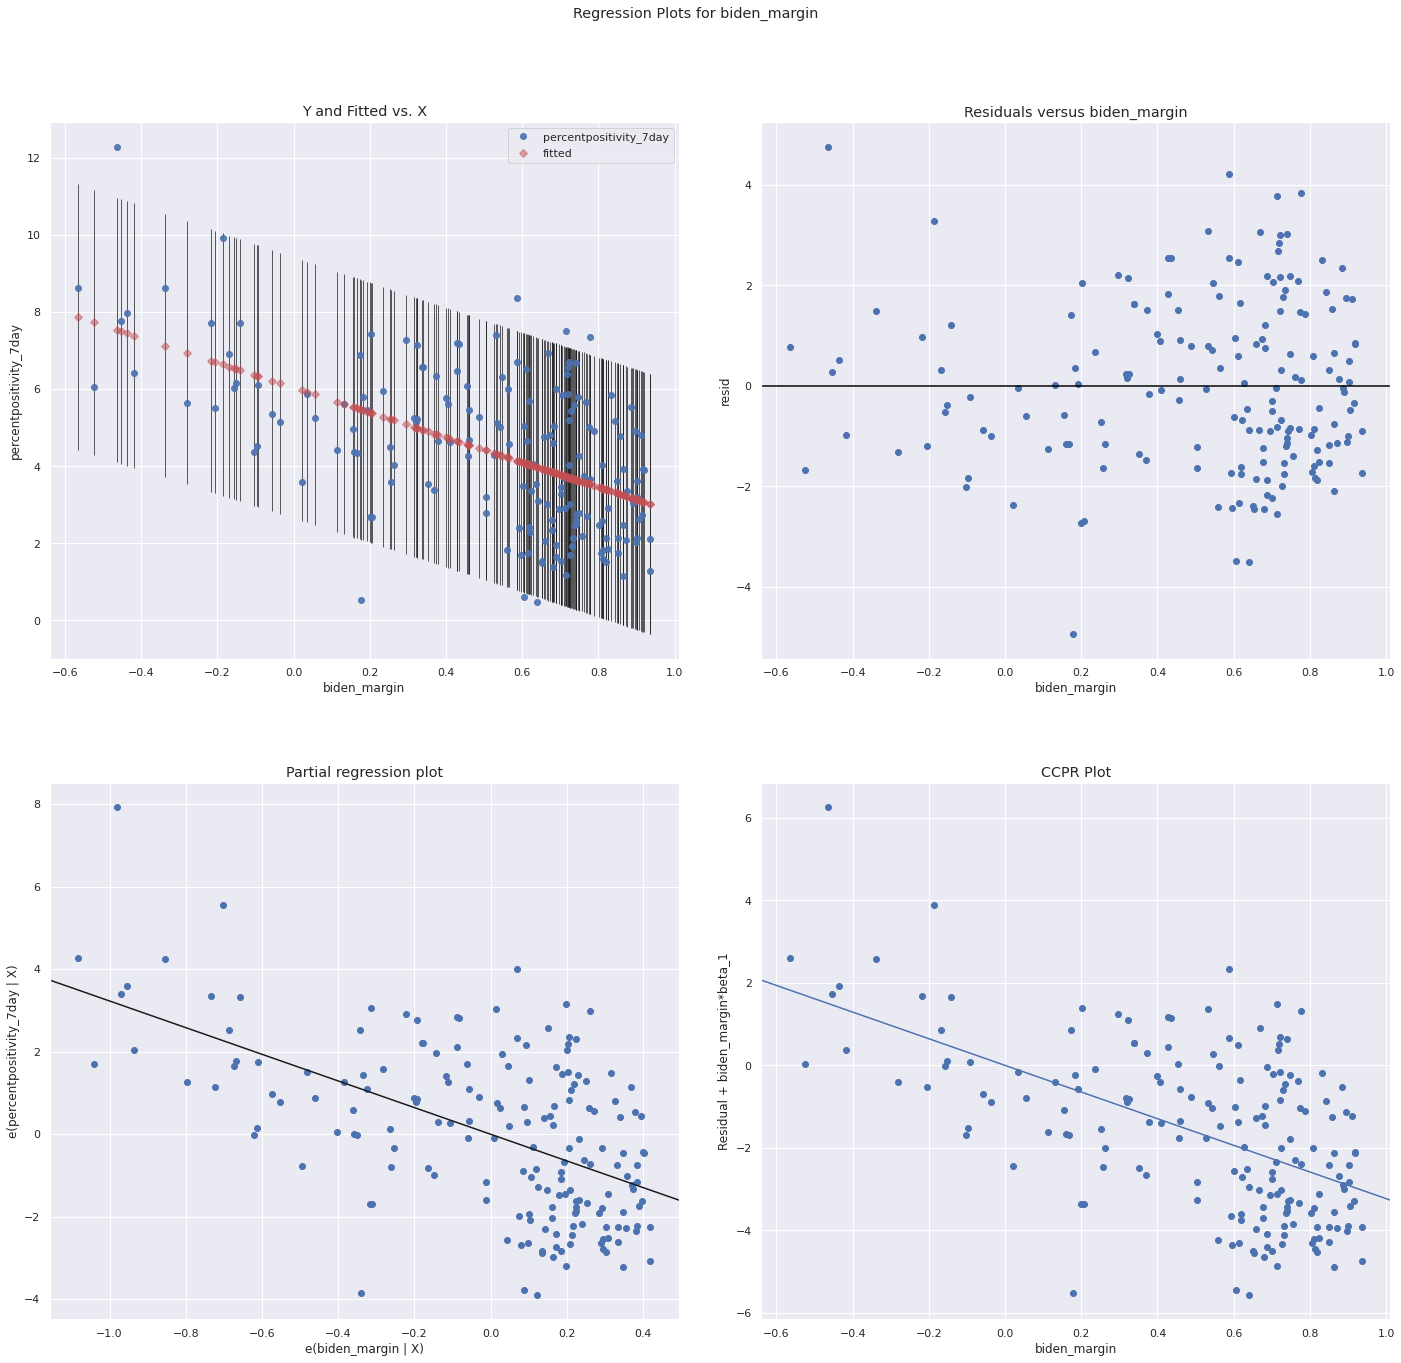

In [ ]:
fig = sm.graphics.plot_regress_exog(lm, "biden_margin")
fig.set_size_inches(20, 20)